# Interpretability Techniques for single samples from FUNSD

## Github

In [1]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 1669, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 1669 (delta 119), reused 119 (delta 59), pack-reused 1472 (from 1)
Receiving objects: 100% (1669/1669), 28.47 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (1058/1058), done.


In [43]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 429 bytes | 429.00 KiB/s, done.
From https://github.com/adamserag1/Interpretability-for-VRDU-models
 * branch            HEAD       -> FETCH_HEAD
Updating af73ed0..031a036
Fast-forward
 Eval/eval_suite_updated.py | 2 ++
 1 file changed, 2 insertions(+)


In [2]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install -U datasets

## Libraries

In [44]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForTokenClassification, AutoProcessor, BrosForTokenClassification, AutoTokenizer, AutoConfig
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain') or module.startswith('lime') or module.startswith('Eval'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
from Eval.eval_suite import *
from Eval.fidelity import *
from Classification_Explain.shap import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Reloading module: vrdu_utils.module_types
Reloading module: vrdu_utils.utils
Reloading module: vrdu_utils.encoders
Reloading module: vrdu_utils
Reloading module: lime
Reloading module: lime.discretize
Reloading module: lime.exceptions
Reloading module: lime.explanation
Reloading module: lime.lime_base
Reloading module: lime.lime_tabular
Reloading module: lime.wrappers
Reloading module: lime.utils
Reloading module: lime.utils.generic_utils
Reloading module: lime.wrappers.scikit_image
Reloading module: lime.lime_image
Reloading module: Classification_Explain.lime
Reloading module: Classification_Explain.shap
Reloading module: Classification_Explain
Reloading module: Eval.fidelity
Reloading module: Eval.eval_suite
Reloading module: Eval
Reloading module: Eval.eval_suite_updated


## Data & Model Setup

In [6]:
FUNSD = load_dataset("nielsr/funsd")
label_list = FUNSD["train"].features["ner_tags"].feature.names
id2label = {v:k for v,k in enumerate(label_list)}
label2id = {k:v for v,k in enumerate(label_list)}
funsd_test = FUNSD["test"]
test_ds = DocSampleDataset(funsd_test)
print(label_list)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [7]:
LLMV3 = LayoutLMv3ForTokenClassification.from_pretrained('adamadam111/layoutlmv3-finetuned-funsd', num_labels = len(label_list), id2label = id2label, label2id = label2id)
LLMV3_proc = AutoProcessor.from_pretrained('adamadam111/layoutlmv3-finetuned-funsd', apply_ocr=False)


BROS = BrosForTokenClassification.from_pretrained('adamadam111/bros-funsd-finetuned', num_labels = len(label_list), id2label = id2label, label2id = label2id)
BROS_t = AutoTokenizer.from_pretrained('adamadam111/bros-funsd-finetuned')

BROS.to(device)
LLMV3.to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [8]:
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc, ner=True)
BROS_encode = make_bros_encoder(BROS_t, ner=True)

## Finding Samples

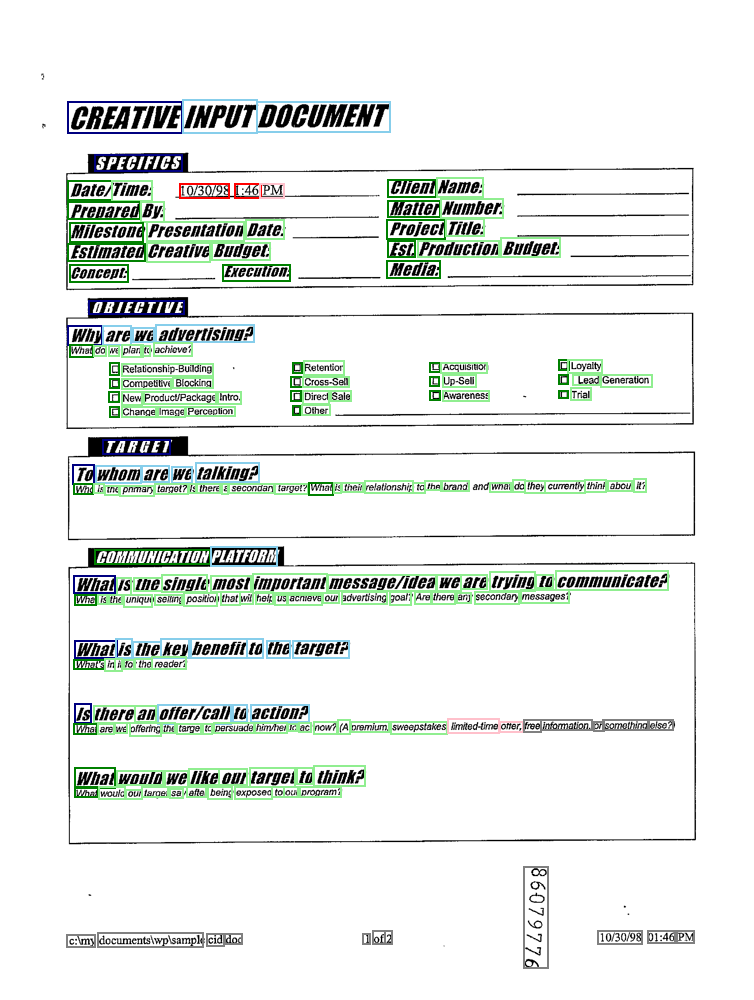

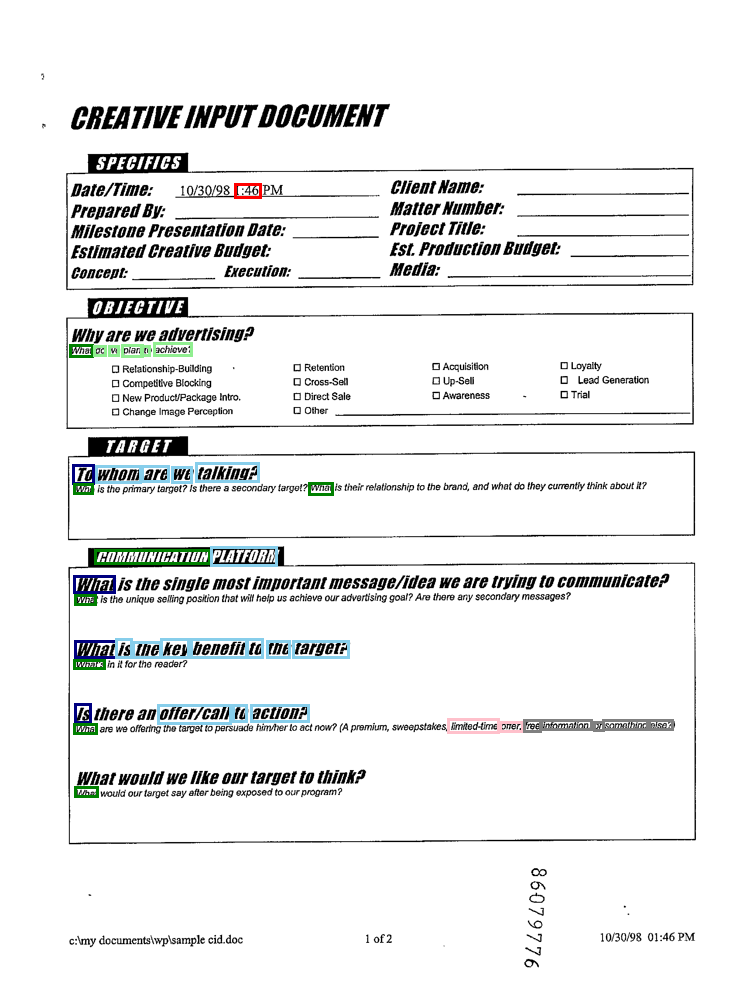

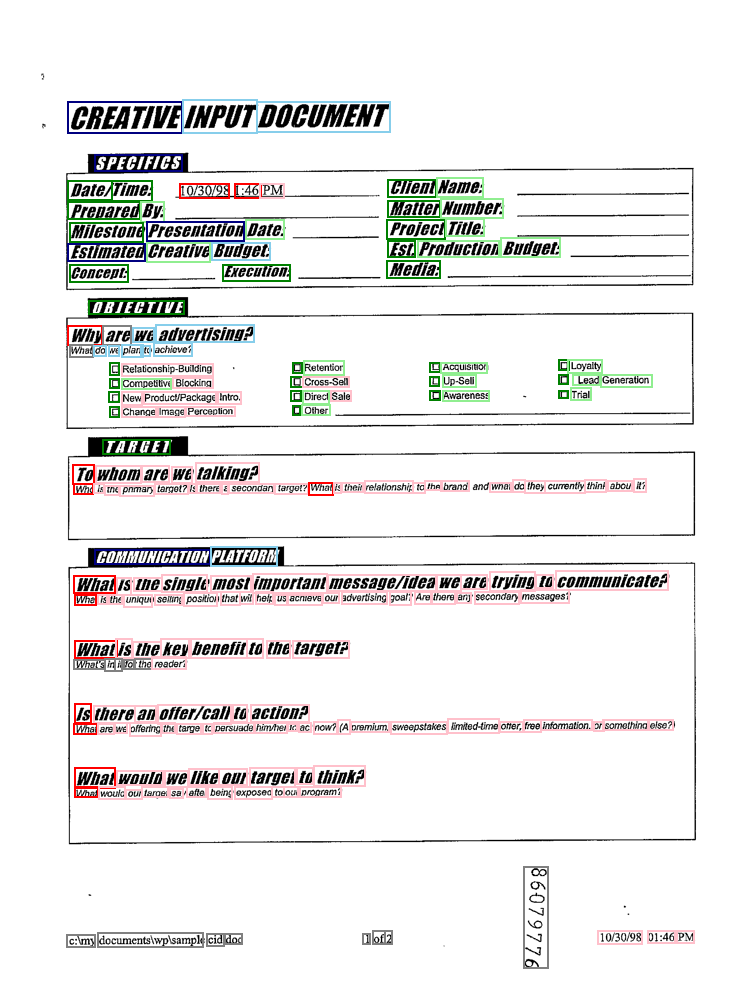

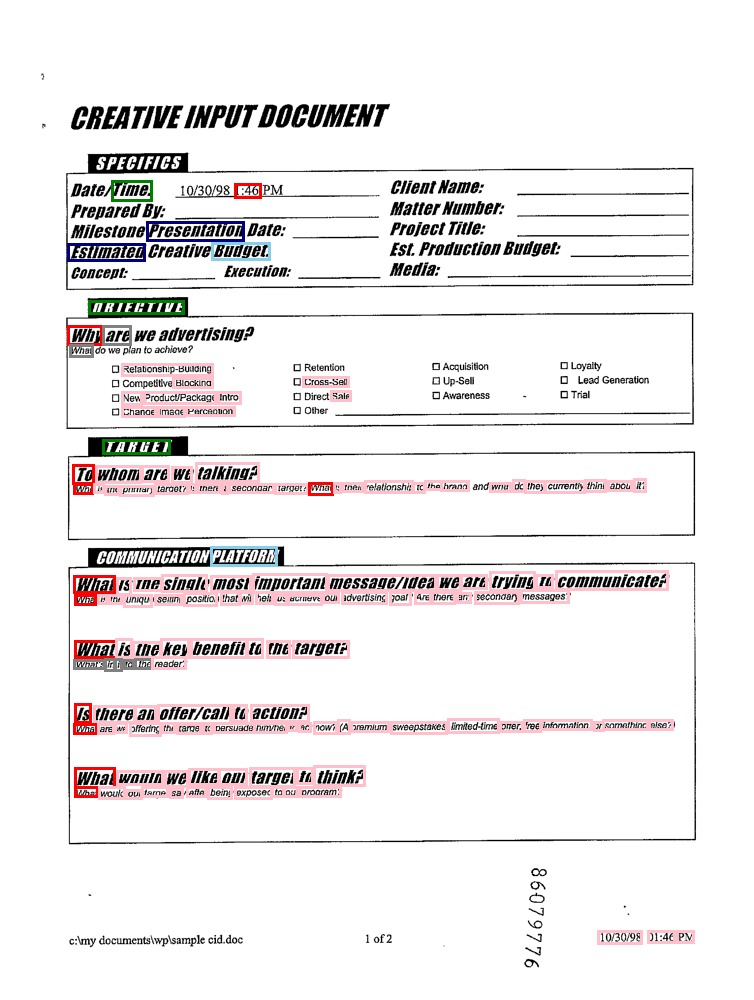

In [ ]:
TAG_COLOURS = {
    "O":          "gray",
    "B-HEADER":   "navy",
    "I-HEADER":   "skyblue",
    "B-QUESTION": "green",
    "I-QUESTION": "lightgreen",
    "B-ANSWER":   "red",
    "I-ANSWER":   "pink",
}

# ──────────────────────────────────────────────────────────────────────────────
# 1️⃣  Helper: draw a single page with coloured boxes
# ──────────────────────────────────────────────────────────────────────────────
def draw_page_with_tags(img_path, bboxes, tag_names, tag_colours=TAG_COLOURS, width=2):
    """
    img_path  : path to the page image (png / jpg)
    bboxes    : list of [x1,y1,x2,y2] *pixel* boxes, one per word
    tag_names : list of str labels (same length as bboxes)
    width     : outline thickness
    returns   : PIL.Image with coloured rectangles
    """
    img = img_path.convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size
    bboxes = [unnormalize_box(bbox, w, h) for bbox in bboxes]
    for box, tag in zip(bboxes, tag_names):
        colour = tag_colours.get(tag, "black")       # fallback to black
        draw.rectangle(box, outline=colour, width=width)

    return img

# ──────────────────────────────────────────────────────────────────────────────
# 2️⃣  Helper: word-level predictions for ONE model on ONE sample
#     (uses your existing encode_fn + model)
# ──────────────────────────────────────────────────────────────────────────────
def _get_word_preds(sample, model, encode_fn, id2label, device="cuda"):
    """
    Word-level predictions perfectly aligned with sample['words'].
    – no double box-normalisation
    – no CLS/SEP leakage
    – robust to truncation
    """
    model.eval()

    # ❶ keep FUNSD boxes as-is (0-1000)
    ds = DocSample(
        image    = sample["image"],
        words    = sample["words"],
        bboxes   = sample["bboxes"],
        ner_tags = sample["ner_tags"],
    )

    # ❷ make sure encode_fn returns the *original* BatchEncoding
    enc, _ = encode_fn([ds], device)          # <-- enc is BatchEncoding, not dict
    enc.to(device)
    with torch.no_grad():
        logits = model(**enc).logits[0]     # (seq_len, n_labels)

    pred_ids = logits.argmax(-1).tolist()
    word_ids = enc.word_ids(batch_index=0)  # mapping sub-token → word-idx

    preds, prev_wid = [], None
    for tok_idx, wid in enumerate(word_ids):
        if wid is None or wid == prev_wid:     # skip CLS/SEP & extra subtokens
            continue
        preds.append(id2label[pred_ids[tok_idx]])
        prev_wid = wid
        if len(preds) == len(sample["ner_tags"]):   # stop if page was truncated
            break

    return preds
def visualise_error_boxes(
    sample,
    model_a, encode_a,
    model_b, encode_b,
    id2label,
    device="cpu",
):
    # predictions
    tags_a = _get_word_preds(sample, model_a, encode_a, id2label, device)
    tags_b = _get_word_preds(sample, model_b, encode_b, id2label, device)

    # ground-truth tag names
    gt_tags = [id2label[i] for i in sample["ner_tags"]]

    # images that highlight ONLY the mistakes
    err_a = draw_page_errors(sample["image"], sample["bboxes"],
                             tags_a, gt_tags)
    err_b = draw_page_errors(sample["image"], sample["bboxes"],
                             tags_b, gt_tags)

    return err_a, err_b

def draw_page_errors(img,
                     bboxes,
                     pred_tags,
                     gt_tags,
                     tag_colours=TAG_COLOURS,
                     width=3):
    """
    Like draw_page_with_tags, but draws a rectangle *only* when
    pred_tags[i] != gt_tags[i].
    The outline colour still reflects the model’s **predicted** tag.
    """
    canvas = img.convert("RGB").copy()
    draw   = ImageDraw.Draw(canvas)
    W, H   = canvas.size
    pix_boxes = [unnormalize_box(b, W, H) for b in bboxes]

    for box, p_tag, g_tag in zip(pix_boxes, pred_tags, gt_tags):
        if p_tag != g_tag:                       # model got it wrong
            colour = tag_colours.get(p_tag, "black")
            draw.rectangle(box, outline=colour, width=width)

    return canvas

# ──────────────────────────────────────────────────────────────────────────────
# 3️⃣  Main routine: run two models, return two coloured images
# ──────────────────────────────────────────────────────────────────────────────
def visualise_two_models(
    sample,                              # dict or DocSample
    model_a, encode_a,                   # first model + encoder
    model_b, encode_b,                   # second model + encoder
    id2label,                            # id → tag string map
    device="cpu",
):
    # predictions
    tags_a = _get_word_preds(sample, model_a, encode_a, id2label, device)
    tags_b = _get_word_preds(sample, model_b, encode_b, id2label, device)

    # coloured pages
    img_a  = draw_page_with_tags(sample["image"], sample["bboxes"], tags_a)
    img_b  = draw_page_with_tags(sample["image"], sample["bboxes"], tags_b)

    return img_a, img_b


page = FUNSD["test"][29]                        # or your DocSample instance

img_llmv3, img_bros = visualise_two_models(
    page,
    LLMV3, LLMV3_encode,
    BROS , BROS_encode,
    id2label,
    device=device,
)

# NEW: error-only overlays
err_llmv3, err_bros = visualise_error_boxes(
    page, LLMV3, LLMV3_encode, BROS, BROS_encode, id2label, device=device
)

display(img_llmv3)      # all predictions from model A
display(err_llmv3)      # only the wrong ones from model A
display(img_bros)       # all predictions from model B
display(err_bros)

# TAG_COLOURS = {
#     "O":          "gray",
#     "B-HEADER":   "navy",
#     "I-HEADER":   "skyblue",
#     "B-QUESTION": "green",
#     "I-QUESTION": "lightgreen",
#     "B-ANSWER":   "red",
#     "I-ANSWER":   "pink",
# }


In [34]:
expample = FUNSD['test'][29]
example = DocSample(
        image    = expample["image"],
        words    = expample["words"],
        bboxes   = expample["bboxes"],
        ner_tags = expample["ner_tags"],
    )
target_word = 'OBJECTIVE'
target_idx = 0

for i,t in enumerate(example.words):
  if t == target_word:
    target_idx = i

def target_token_fn(enc, *, batch_index: int = 0):
  print(enc.keys())
  try:
    word_ids = enc.word_ids(batch_index=batch_index)
  except:
    word_ids = enc
  for tok_idx, wid in enumerate(word_ids):
      if wid == target_idx:
          return tok_idx
print(target_idx)

target_label = label2id['B-HEADER']

3


## Text

In [10]:
text_explainers = {
    'LLMV3 lime' : LimeTextNer(LLMV3, LLMV3_encode, mask_token=LLMV3_proc.tokenizer.mask_token, device = device, kernel_width_factor=0.75, target_token_fn=target_token_fn, labels = [target_label]),
    'LLMV3 shap' : SHAPTextNer(LLMV3, LLMV3_encode, tokenizer=LLMV3_proc.tokenizer, mask_token=LLMV3_proc.tokenizer.mask_token, device = device, target_token_fn=target_token_fn),
    'BROS lime' : LimeTextNer(BROS, BROS_encode, mask_token=BROS_t.mask_token, device = device, kernel_width_factor=0.75, target_token_fn=target_token_fn, labels=[3]), # 3 as falsley predicted as B-QUESTION
    'BROS shap' : SHAPTextNer(BROS, BROS_encode, tokenizer=BROS_t ,mask_token=BROS_t.mask_token, device = device, target_token_fn=target_token_fn),
}


In [ ]:
print(example)

DocSample(image=<PIL.PngImagePlugin.PngImageFile image mode=L size=754x1000 at 0x7E14EF698410>, words=['TO:', 'DATE:', '3', 'Fax:', 'NOTE:', '82092117', '614', '-466', '-5087', 'Dec', '10', "'98", '17', ':46', 'P.', '01', 'ATT.', 'GEN.', 'ADMIN.', 'OFFICE', 'Attorney', 'General', 'Betty', 'D.', 'Montgomery', 'CONFIDENTIAL', 'FACSIMILE', 'TRANSMISSION', 'COVER', 'SHEET', '(614)', '466-', '5087', 'FAX', 'NO.', 'George', 'Baroody', '(336)', '335-', '7392', 'FAX', 'NUMBER:', 'PHONE', 'NUMBER:', '(336)', '335-', '7363', 'NUMBER', 'OF', 'PAGES', 'INCLUDING', 'COVER', 'SHEET:', 'June', 'Flynn', 'for', 'Eric', 'Brown/', '(614)', '466-', '8980', 'SENDER', '/PHONE', 'NUMBER:', 'SPECIAL', 'INSTRUCTIONS:', 'IF', 'YOU', 'DO', 'NOT', 'RECEIVE', 'ANY', 'OF', 'THE', 'PAGES', 'PROPERLY,', 'PLEASE', 'CONTACT', 'SENDER', 'AS', 'SOON', 'AS', 'POSSIBLE', 'THIS', 'MESSAGE', 'IS', 'INTENDED', 'ONLY', 'FOR', 'THE', 'USE', 'OF', 'THE', 'INDIVIDUAL', 'OR', 'ENTITY', 'TO', 'WHOM', 'IT', 'IS', 'ADDRESSED', 'AND',

In [11]:
text_explanations = {key : text_explainers[key].explain(example) for key in text_explainers}

Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 250/250 [01:53<00:00,  2.19it/s]
PermutationExplainer explainer: 2it [00:50, 50.80s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]
PermutationExplainer explainer: 2it [00:23, 23.66s/it]               


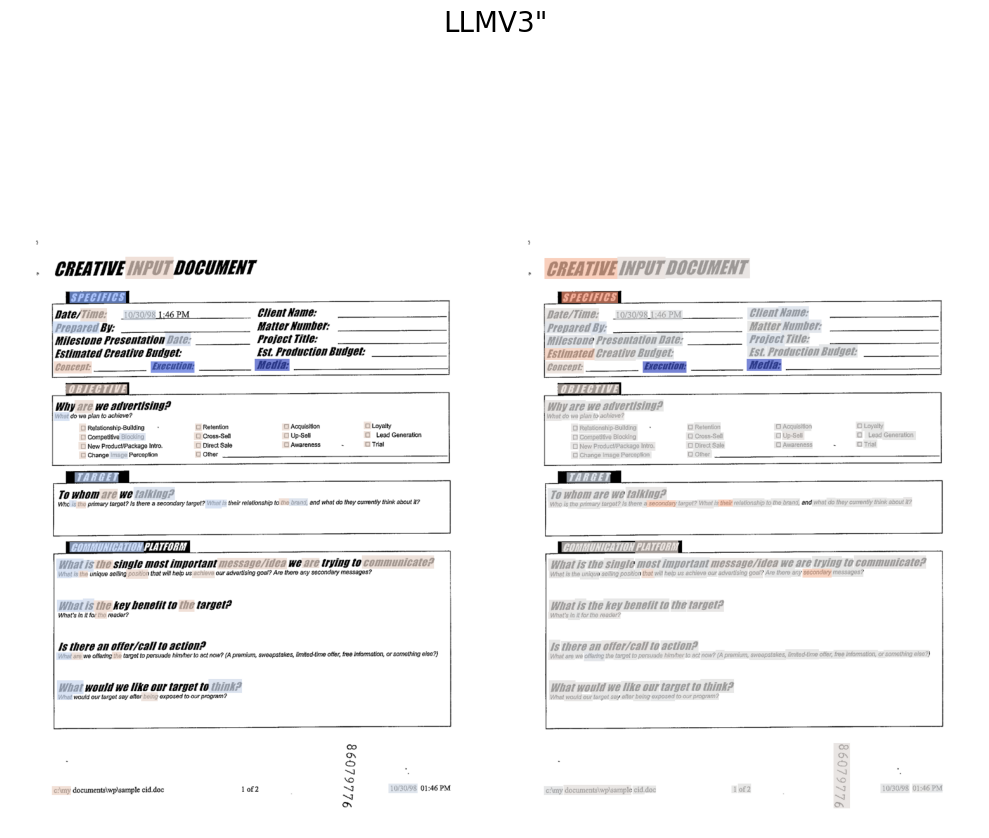

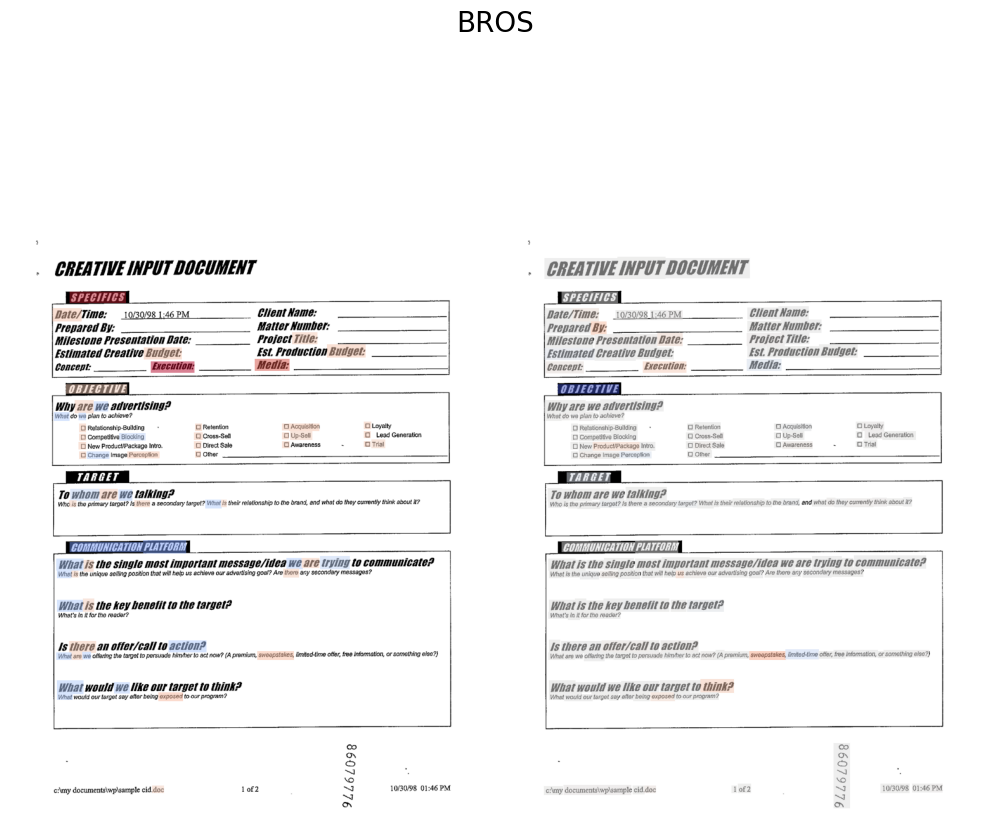

In [ ]:
text_explanations_hms = {}
text_explanations_weights = {}
w, h = example.image.size
bboxes = [unnormalize_box(bbox, w, h) for bbox in example.bboxes]

def get_bros_weights_and_hm(key, explanation, global_weights_dict):
  if 'lime' in key:
    weights = dict(explanation.as_list(label=3))
    weights = {key.replace('=1', ''): value for key, value in weights.items()}
    global_weights_dict.update({key : weights})
  else:
    weights = {tok : float(val) for tok, val in zip(example.words, explanation.values[:,:,3].flatten())}
    global_weights_dict.update({key : weights})
  hm = draw_lime_token_heatmap(image = example.image, words = example.words, boxes = bboxes, weights=weights, alpha=0.5)
  return hm

def get_llmv3_weights_and_hm(key, explanation, global_weights_dict):
  if 'lime' in key:
    weights = dict(explanation.as_list(label=target_label))
    weights = {key.replace('=1', ''): value for key, value in weights.items()}
    global_weights_dict.update({key : weights})
  else:
    weights = {tok : float(val) for tok, val in zip(example.words, explanation.values[:,:,target_label].flatten())}
    global_weights_dict.update({key : weights})
  hm = draw_lime_token_heatmap(image = example.image, words = example.words, boxes = bboxes, weights=weights, alpha=0.7)
  return hm

llmve_hms = [get_llmv3_weights_and_hm(key, text_explanations[key], text_explanations_weights) for key in text_explanations if 'LLMV3' in key]
bros_hms = [get_bros_weights_and_hm(key, text_explanations[key], text_explanations_weights) for key in text_explanations if 'BROS' in key]
display_image_grid(llmve_hms,
                   [f'', f''],
                    (1,2),
                   main_title='LLMV3"')
display_image_grid(bros_hms,
                   [f'',f''],
                   (1,2),
                   main_title='BROS'
                   )

In [ ]:
ner_fidelity = FidelityEvaluator(
    model          = LLMV3,
    encode_fn      = LLMV3_encode,
    mask_token     = LLMV3_proc.tokenizer.mask_token,
    target_token_fn= target_token_fn,    # NEW
    target_label_id= target_label,    # NEW
    device         = device,
)
pred_fn = ner_fidelity._get_prediction_function(3)
calculate_sufficiency(predict_fn=pred_fn, sample=example,explanation=text_explanations_weights['LLMV3 shap'] , mask_token = LLMV3_proc.tokenizer.mask_token, top_k=1)

Kept top 1 text tokens
[SUF] original probability: 0.9690176844596863, perturbed_probability: 0.8372665643692017


0.13175112009048462

## Layout

In [12]:
layout_explainers = {
    'LLMV3 lime' : LimeLayoutNer(LLMV3, LLMV3_encode, mask_token=LLMV3_proc.tokenizer.mask_token, device = device, kernel_width_factor=0.75, target_token_fn=target_token_fn, labels = [target_label]),
    'LLMV3 shap' : SHAPLayoutNer(LLMV3, LLMV3_encode, device = device, target_token_fn=target_token_fn),
    'BROS lime' : LimeLayoutNer(BROS, BROS_encode, mask_token=BROS_t.mask_token, device = device, kernel_width_factor=0.75, target_token_fn=target_token_fn, labels=[3]),
    'BROS shap' : SHAPLayoutNer(BROS, BROS_encode , device = device, target_token_fn=target_token_fn),
}


In [14]:
layout_explanations = {key : layout_explainers[key].explain(example) for key in layout_explainers}

Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s]
PermutationExplainer explainer: 2it [00:45, 45.34s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]
PermutationExplainer explainer: 2it [00:23, 23.88s/it]               


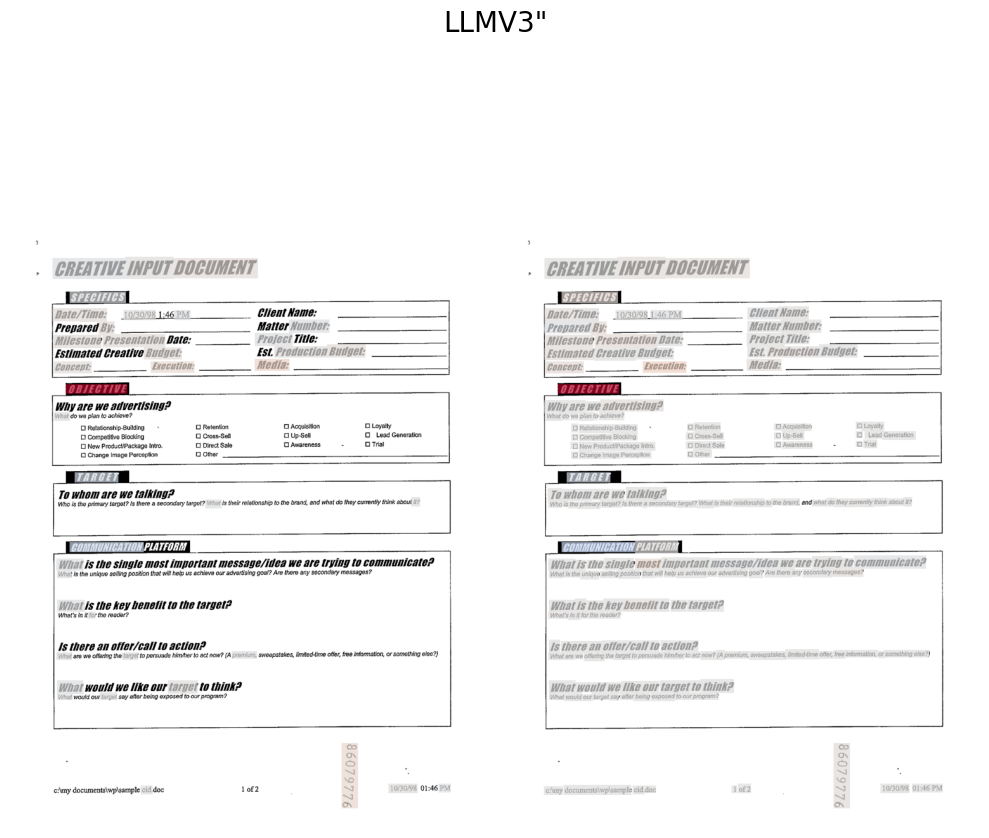

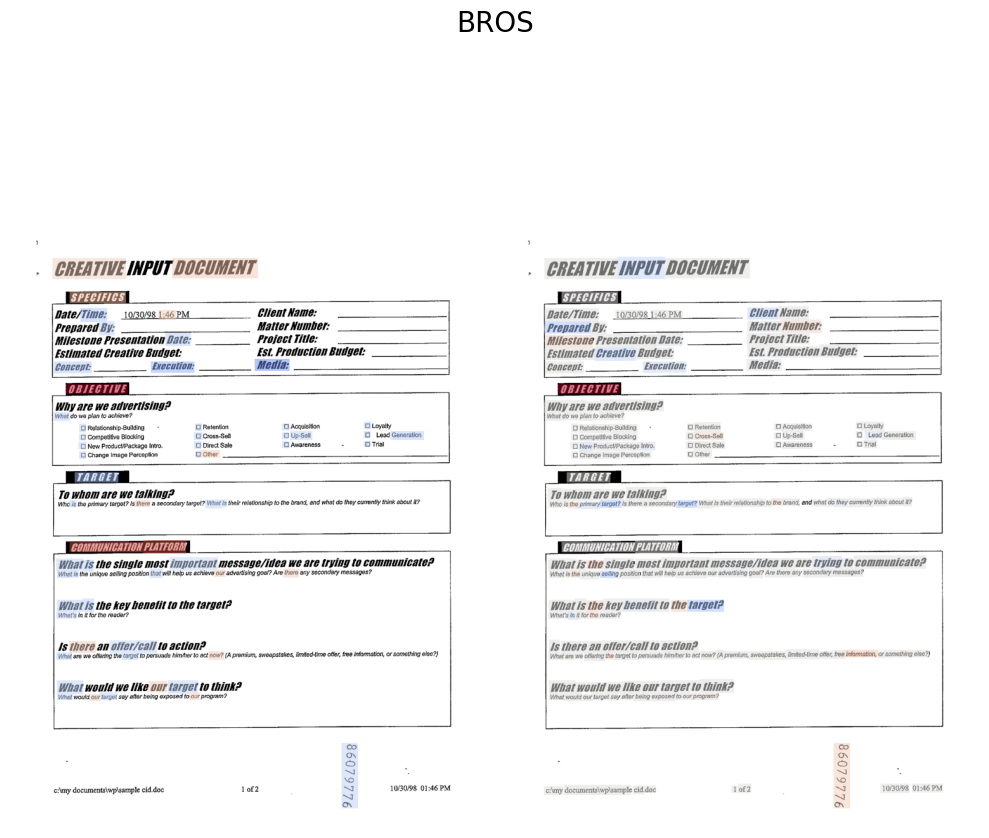

In [ ]:
layout_explanations_hms = {}
layout_explanations_weights = {}
w, h = example.image.size
bboxes = [unnormalize_box(bbox, w, h) for bbox in example.bboxes]
layout_llmv3_hms = [get_llmv3_weights_and_hm(key, layout_explanations[key], layout_explanations_weights) for key in layout_explanations if 'LLMV3' in key]
layout_bros_hms = [get_bros_weights_and_hm(key, layout_explanations[key], layout_explanations_weights) for key in layout_explanations if 'BROS' in key]

display_image_grid(layout_llmv3_hms,
                   [f'', f''],
                    (1,2),
                   main_title='LLMV3"')
display_image_grid(layout_bros_hms,
                   [f'',f''],
                   (1,2),
                   main_title='BROS'
                   )
# for key, explanation in layout_explanations.items():
#   if 'lime' in key:
#     weights = dict(layout_explanations[key].as_list(label=3))
#     weights = {key.replace('=1', ''): value for key, value in weights.items()}
#     layout_explanations_weights.update({key : weights})
#     layout_explanations_hms.update({key : draw_lime_token_heatmap(image = example.image, words = example.words, boxes = bboxes, weights=weights, alpha=0.5) })
#   if 'shap' in key:
#     weights = {tok : float(val) for tok, val in zip(example.words, layout_explanations[key].values[:,:,3].flatten())}
#     layout_explanations_weights.update({key : weights})
#     layout_explanations_hms.update({key : draw_lime_token_heatmap(image = example.image, words = example.words, boxes = bboxes, weights=weights, alpha=0.5) })


# display_image_grid([layout_explanations_hms['LLMV3 lime'], layout_explanations_hms['LLMV3 shap']],
#                    [f'', f''],
#                     (1,2),
#                    main_title='Layout LMV3"')

# display_image_grid([layout_explanations_hms['BROS lime'], layout_explanations_hms['BROS shap']],
#                    [f'', f''],
#                     (1,2),
#                    main_title='BROS"')


## Vision

In [13]:
vision_explainers = {
    'LLMV3 lime' : LimeVisionNer(LLMV3, LLMV3_encode, device=device, target_token_fn=target_token_fn, label = [target_label]),
    'LLMV3 shap' : SHAPVisionNer(LLMV3, LLMV3_encode, device = device, class_idx=1,mask_value='blur(64,64)',target_token_fn=target_token_fn),
}


In [15]:
vision_explanations = {key: vision_explainers[key].explain(example, nsamples=1000) for key in vision_explainers if 'shap' in key}
vision_explanations.update({key: vision_explainers[key].explain(example, num_samples=1000) for key in vision_explainers if 'lime' in key})

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:42, 42.02s/it]               


  0%|          | 0/1000 [00:00<?, ?it/s]

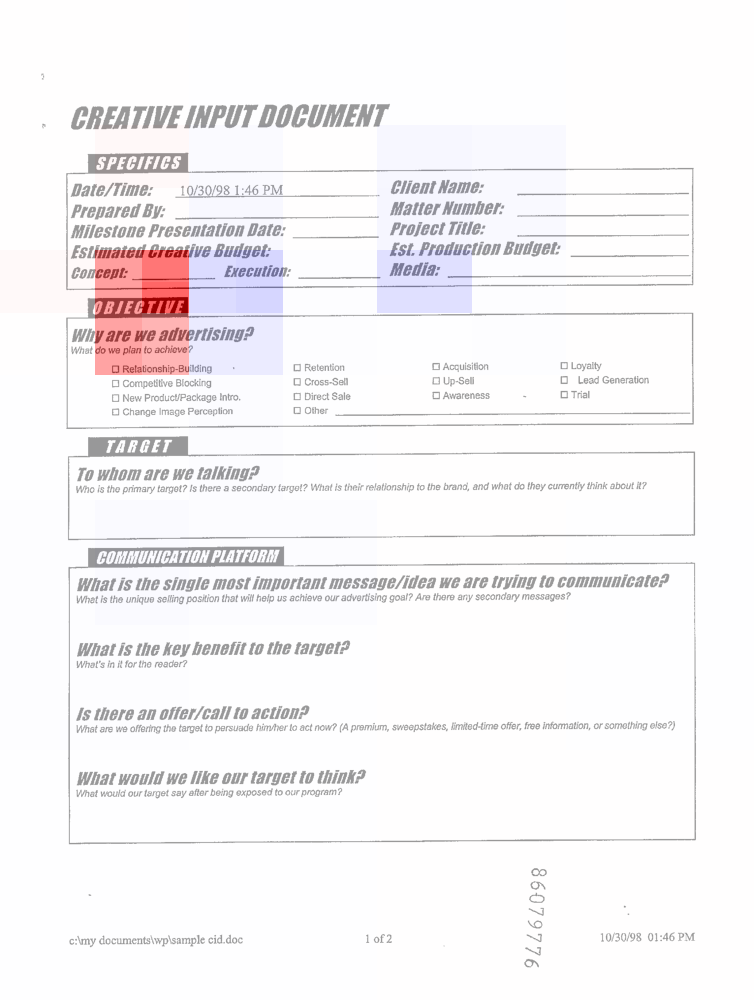

In [ ]:
def shap_overlay(exp, alpha=0.6, cmap="bwr"):
    vals  = exp.values          # (H,W) or (H,W,3)
    img   = exp.data.astype(np.uint8)   # (H,W,3)

    if vals.ndim == 3:                   # SHAP gave per-channel values
        vals = vals.mean(2)              # collapse to one heat-map

    vmax  = np.abs(vals).max() + 1e-12
    norm  = (vals + vmax) / (2 * vmax)   # 0…1
    rgb   = plt.get_cmap(cmap)(norm)[..., :3] * 255  # (H,W,3) uint8
    blend = (img*(1-alpha) + rgb*alpha).astype(np.uint8)
    return Image.fromarray(blend)

shap_overlay(vision_explanations['LLMV3 shap'], alpha=0.6)

/tmp/ipython-input-782240857.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color  = np.array(cm.get_cmap(cmap)((w+vmax)/(2*vmax))[:3]) * 255


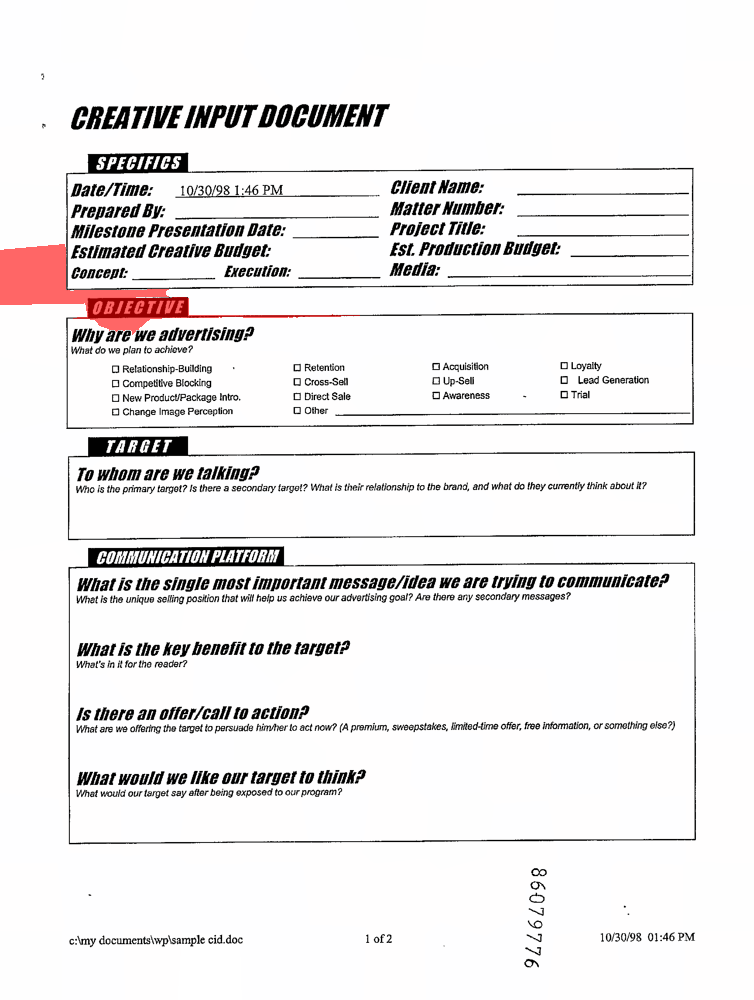

In [ ]:
def lime_heatmap(expl, class_idx=1, alpha_max=0.6, cmap="bwr"):
    img     = expl.image.astype(float)                          # (H,W,3)
    segs    = expl.segments                                     # (H,W) labels
    weights = dict(expl.local_exp[class_idx])                   # {seg: w}
    vmax    = max(abs(w) for w in weights.values()) + 1e-12     # normaliser

    overlay = img.copy()
    for seg_id, w in weights.items():
        mask   = segs == seg_id                                 # (H,W) bool
        color  = np.array(cm.get_cmap(cmap)((w+vmax)/(2*vmax))[:3]) * 255
        alpha  = alpha_max * abs(w) / vmax                      # 0 → alpha_max
        overlay[mask] = overlay[mask]*(1-alpha) + color*alpha

    return Image.fromarray(overlay.astype(np.uint8))
lime_heatmap(vision_explanations['LLMV3 lime'],alpha_max=0.6)

## MM-SHAP

In [ ]:
print(vision_explanations['LLMV3 shap'])

.values =
array([[[ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        ...,
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08],
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08],
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08]],

       [[ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        ...,
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08],
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08],
        [ 4.69540095e-08,  4.69540095e-08,  4.69540095e-08]],

       [[ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        [ 1.52557959e-08,  1.52557959e-08,  1.52557959e-08],
        ...,
        [ 4.69540095e-08,  4.695

In [ ]:
def mm_shap_contributions(**shap_by_modality):
    """
    Returns the per-modality MM-SHAP contribution scores *in percent*.

    Parameters
    ----------
    **shap_by_modality
        Keyword arguments of the form
            text   = <1-D array or list of SHAP values for all text tokens>
            layout = <SHAP values for all boxes>               (optional)
            vision = <SHAP values for all image segments>      (optional)
        You can pass any number of modalities; names are kept in the output.

    Returns
    -------
    contrib : dict { modality → percentage }
        Each value is 100 · Φ_m / Σ_k Φ_k  where
            Φ_m = Σ_i |ϕ_i|   (absolute Shapley values of modality *m*).
        The scores add up to ~100 (± machine precision).
    """
    # ❶  absolute sums per modality

    phi = {mod: float(np.abs(vals).sum()) for mod, vals in shap_by_modality.items()}

    # ❷  avoid division-by-zero when all Φ_m are 0
    total = sum(phi.values()) or 1.0

    # ❸  percentages
    return {mod: 100.0 * val / total for mod, val in phi.items()}

mm_shap_llmv3 = mm_shap_contributions(text=text_explanations['LLMV3 shap'].values[:,:,target_label], layout=layout_explanations['LLMV3 shap'].values[:,:,target_label], vision=vision_explanations['LLMV3 shap'].values)
mm_shap_bros = mm_shap_contributions(text=text_explanations['BROS shap'].values[:,:,3], layout=layout_explanations['BROS shap'].values[:,:,3])
print(mm_shap_llmv3)
print(mm_shap_bros)

{'text': 46.93345928115537, 'layout': 28.906812286008844, 'vision': 24.159728432835795}
{'text': 49.20565678176553, 'layout': 50.79434321823447}


In [45]:
from skimage.segmentation import slic

# all vision explanations will share the same SLIC grid
SLIC_KW = dict(n_segments=200, compactness=20.0, sigma=1.0, start_label=1)

def extract_weights(expl, modality: str, cls_idx: int,
                    sample: DocSample | None = None,
                    slic_kw: dict = SLIC_KW):
    """
    Turn a *raw* explanation object into a simple {id → weight} mapping
    that evaluate_sample() understands.

    Returns
    -------
    weights   : dict {feature-id → weight}
    segments  : np.ndarray | None            (only for vision)
    """
    # --------------------------- LIME ---------------------------------- #
    if hasattr(expl, "local_exp"):                    # any Lime* object
        if modality == "vision":                      #   ── VISION ──
            w = {int(seg): float(val)
                 for seg, val in expl.local_exp[cls_idx]}
            return w, expl.segments
        else:                                         # text / layout
            m = expl.as_map()[cls_idx]                # list[(id, w)]
            return {int(fid): float(w) for fid, w in m}, None

    # --------------------------- SHAP ---------------------------------- #
    if hasattr(expl, "values"):
        vals = expl.values
        # –– TEXT & LAYOUT –––––––––––––––––––––––––––––––––––––––––––––––
        if modality in ("text", "layout"):
            while vals.ndim > 2:      # drop dummy batch dim
                vals = vals[0]
            if vals.ndim == 2:        # (tokens, classes)
                vals = vals[:, cls_idx]
            return {i: float(v) for i, v in enumerate(vals)}, None
        # –– VISION ––––––––––––––––––––––––––––––––––––––––––––––––––––––
        if modality == "vision":
            if sample is None:
                raise ValueError("sample must be supplied for SHAP-vision.")
            if vals.ndim == 4:        # (1, H, W, 3)
                vals = vals[0]
            if vals.ndim == 3:        # RGB → mean over channels
                vals = vals.mean(-1)

            img_np = np.asarray(sample.image)
            seg = slic(img_np,
                       channel_axis=-1 if img_np.ndim == 3 else None,
                       **slic_kw)
            w = {int(sid): float(vals[seg == sid].mean())
                 for sid in np.unique(seg)}
            return w, seg

    raise RuntimeError("Unrecognised explanation object type.")


# ----------------------------------------------------------------------
#  which class-id should we use for each model?
# ----------------------------------------------------------------------
def get_target_class_id(model_tag: str,
                        sample: DocSample,
                        llmv3_fallback: int) -> int:
    """
    LLMV3  →  sample.label  if it exists, otherwise `llmv3_fallback`
    BROS   →  3
    """
    if model_tag.upper() == "LLMV3":
        return getattr(sample, "label", None) or llmv3_fallback
    return 3


# ----------------------------------------------------------------------
#  main loop – one pass per explanation
# ----------------------------------------------------------------------
MODEL_HANDLES = {                       # str in tag  →  (model , encode_fn)
    "BROS":  (BROS , BROS_encode ),
    "LLMV3": (LLMV3, LLMV3_encode),
}

fidelity_scores = {}   # tag → {"comprehensiveness": …, "sufficiency": …}

for tag, expl in all_expls.items():
    # tag examples:  "[T] LLMV3 lime" , "[V] BROS shap"
    modality  = "text"   if tag.startswith("[T]") else \
               "layout" if tag.startswith("[L]") else "vision"
    model_tag = "LLMV3" if "LLMV3" in tag else "BROS"
    model, encode_fn = MODEL_HANDLES[model_tag]

    # the very DocSample you created above
    sample = example
    cls_id = get_target_class_id(model_tag, sample, llmv3_fallback=target_label)

    # ① explanation → (weights, segments*)
    weights, seg = extract_weights(expl, modality, cls_id, sample)

    # ② run fidelity metrics
    metrics = evaluate_sample(
        sample,
        weights,
        modality,
        model, encode_fn,
        top_k            = 20,
        device           = device,
        target_token_fn  = target_token_fn,   # token-level NER
        target_label_id  = cls_id,            # B-HEADER or 3
        segments         = seg,               # only for vision
    )

    fidelity_scores[tag] = metrics
    print(f"{tag:28s}  "
          f"comp = {metrics['comprehensiveness']:.4f}   "
          f"suff = {metrics['sufficiency']:.4f}")

KeysView({'input_ids': tensor([[    0, 44921,  7025, 14864, 44396,    35,  2454,    35, 28214, 33302,
         10002,   255, 40325, 37275,  2371,  6034, 12901,  2571, 38036,   290,
          2466,  5220, 39402, 28122, 39869,  2808, 42030, 34330,  5725,  5382,
         10566,    73,  3421,    35, 13915,  6537,   870,    35,   158,    73,
           541,    73,  5208,   112,    35,  3761,  2784,  5366, 18873, 17356,
          1258, 10566,    35, 33991, 14424,  8587,    35, 32253,    35, 33536,
         10704,    35, 18181, 12270,    35,  3728, 13497,    35,  5441,     4,
          9850,  8587,    35,  2612,    32,    52,  4579,   116,   653,   109,
            52,   563,     7,  3042,   116,   598,  2661,    32,    52,  1686,
           116,  3394,    16,     5,  2270,  1002,   116,  1534,    89,    10,
          5929,  1002,   116,   653,    16,    49,  1291,     7,     5,  1518,
            99,   109,    51,   855,   206,    59,    24,   116,   653,    16,
             5,   881,   144,